## Assessment using first principles simulation

In another notebook we have analyzed the relationship between
coronavirus testing data and mortality counts using Poisson
regression.  This is a statistical
approach rather than an explicitly mechanistic approach.  Viral epidemics are
generally modeled using first principles mathematical models that
reflect the assumed disease dynamics.  Here we will simulate data
from a simple compartmental model for a viral epidemic, fit
Poisson regression to it, and assess the extent to which Poisson
regression captures mechanistic features of the epidemic.

A common formalism is to view
the population as being partitioned into compartments of
"susceptible", "infected", "recovered", and "dead" individuals.  In
a discrete-time approach, on each day, the following can happen: (i)
currently infected people can recover, (ii) currently infected
people can die, and (iii) currently infected people can infect
susceptible people.  By specifying probability distributions for the
duration that a newly infected person remains infected, the
probability that an infected person dies (the "infection/fatality
rate"), the duration from infection to recovery or death, and the
number of new infections arising from each infected person (the
"r0", or more precisely, "rt" parameter), we can generate data
following this formalism.

Below we will carry out a simulation using the very simple
compartmental model described above, aiming to roughly capture the
situation for Michigan.  We will model the rt parameter as a
piecewise linear function that starts at 2.2 (a high value) and
remains there for one month.  Then, due to the effect of mitigation
measures, we have the rt decrease linearly from 2.2 to 0.9 over a
duration of 20 days.  The rt remains at 0.9 thereafter.

The main goal here is to see how the Poisson regression model
performs when fed data generated according to a commonly-utilized
probability model for epidemics.

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

Make the notebook reproducible.

In [2]:
np.random.seed(3443)

In [3]:
# Simulate for this number of days
ntime = 85

# Infection fatality rate
ifr = 0.01

# Information characterizing one person
class person:

    # Day on which the person was infected
    infection_day = 0

    # True if the person recovers, False if they die
    recover = True

    # The time duration from infection to recovery or death
    duration = 0

    # The number of people infected by this person
    infects = 0

    def get_rt(self, d):

        # The initial rt and final rt
        r0 = 2.5
        r1 = 0.9

        # Due to mitigation, the rt value drops from r0 to r1
        # between days d0 and d1.
        d0, d1 = 20, 40

        # Calculate the rt value on day d
        if d <= d0:
            rt = r0
        elif d <= d1:
            rt = r0 - (r0 - r1) * (d - d0) / (d1 - d0)
        else:
            rt = r1
        return rt

    # Generate a random person who is infected on day d.
    def __init__(self, d):

        rt = self.get_rt(d)

        # Day of infection
        self.day = d

        # Does the person recover or die?
        self.recover = np.random.uniform() > ifr
        if self.recover:
            # Duration to recovery
            self.duration = int(np.ceil(-7*np.log(np.random.uniform())))
        else:
            # Duration to death
            self.duration = int(np.ceil(-21*np.log(np.random.uniform())))

        # Number of people infected by this person, give it heavier
        # tails to approximate "super-spreading".
        # b = v/m
        # a = m^2/v
        m = rt
        v = 10.0 * m**2
        self.infects = int(np.round(np.random.gamma(m**2/v, v/m)))

The columns of the array 'sird' correspond to the number of new
infections, new recoveries, new deaths, and active infections on a
given day.  The rows of sird correspond to consecutive days since
the beginning of the epidemic.

The following function updates the numbers rows of 'sird' based on a
set of infected people in 'active'.

In [4]:
def update_mat(active, sird):
    for k, p in enumerate(active):
        if p.day >= ntime:
            continue

        # Update the new infection column
        sird[p.day, 0] += 1

        # The end of the infectious interval
        t = p.day + p.duration

        # Update the active cases column
        sird[p.day:min(t, ntime), 3] += 1

        # The person's outcome occurs in the future
        if t >= ntime:
            continue

        # Update the outcome columns
        if p.recover:
            sird[p.day + p.duration, 1] += 1
        else:
            sird[p.day + p.duration, 2] += 1

    return sird

The following function advances one generation, taking all the
currently infected people and simulating data for the people
infected by them.

In [5]:
def update_people(active):
    active1 = set({})
    for a in active:
        for k in range(a.infects):
            delay = np.random.poisson(4)
            active1.add(person(a.day + delay))
    return active1

In [6]:
np.random.seed(34234)

The following function generates the 'sird' array as described
above.

In [7]:
def gen_sird():

    sird = np.zeros((ntime, 4))

    # Start with 10 seeds on day 0.
    active = set({person(0) for k in range(10)})

    # Loop over ntime/4 generations of transmission (the serial
    # interval is thought to be around 4 days).
    for itr in range(ntime // 4):
        sird = update_mat(active, sird)
        active = update_people(active)

    sird = pd.DataFrame(sird, columns=["I", "R", "D", "A"])

    return sird

Next we need to simulate daily positive and negative test results.
We use a gamma distribution, centered on a value equal to 1/100 of
the population of active cases to produce the positive test results,
and we simulate the negative test results as random values
independent of the disease.  Note that detecting 1/100 of the active
cases on a single day implies that the case/ascertainment ratio is
around 10, if people would test positive for around 10 days during
the course of their illness.

In [8]:
def attach_testing(sird):
    # The relationship between the mean/variance and
    # the gamma distribution parameters.
    # m = a*b
    # v = a*b^2
    # b = v/m
    # a = m^2/v

    # Positive tests
    m = sird.A / 100
    v = 1.0 * m**1.5
    sird["dpositive"] = np.random.gamma(m**2/v, v/m, ntime)

    # Negative tests
    m = 20000
    v = 1.0 * m**1.5
    sird["dnegative"] = np.random.gamma(m**2/v, v/m, ntime)
    return sird

Next we construct the covariates we need, so as to be able to fit
the same model used above for the actual Covid tracking project
data.

In [9]:
# Sum x from d2 days back in time to d1 days back in time, inclusive of
# both endpoints.  d2 must be greater than d1.
def wsum(x, d1, d2):
    w = np.ones(d2 + 1)
    if d1 > 0:
        w[-d1:] = 0
    y = np.zeros_like(x)
    y[d2:] = np.convolve(x.values, w[::-1], mode='valid')
    return y

def attach_covariates(sird):
    for j in range(4):
        sird["cumpos%d" % j] = wsum(sird.dpositive, 7*j, 7*j+6)
        sird["cumneg%d" % j] = wsum(sird.dnegative, 7*j, 7*j+6)
        sird["logcumpos%d" % j] = np.log(sird["cumpos%d" % j] + 1)
        sird["logcumneg%d" % j] = np.log(sird["cumneg%d" % j] + 1)
    return sird

The following function puts everything together:

In [10]:
def generate():
    sird = gen_sird()
    sird = attach_testing(sird)
    sird = attach_covariates(sird)
    return sird

sird = [generate() for k in range(2)]

Below are plots of the simulated number of daily deaths, the
simulated number of active cases, and the simulated number of
positive tests.  The stochastic nature of the daily deaths and
testing data is evident, but the number of active cases appears
non-stochastic.  In fact this is not the case, but at the population
level it appears to be so.

Text(0, 0.5, 'Deaths')

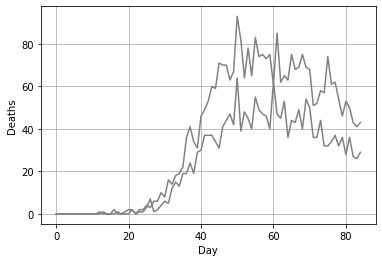

In [11]:
plt.clf()
plt.grid(True)
for x in sird:
    plt.plot(x.D.values, '-', color='grey')
plt.xlabel("Day")
plt.ylabel("Deaths")

Text(0, 0.5, 'Active cases')

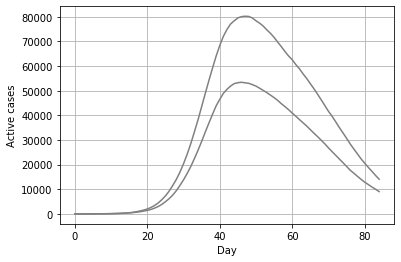

In [12]:
plt.clf()
plt.grid(True)
for x in sird:
    plt.plot(x.A.values, '-', color='grey')
plt.xlabel("Day")
plt.ylabel("Active cases")

Text(0, 0.5, 'Positive tests')

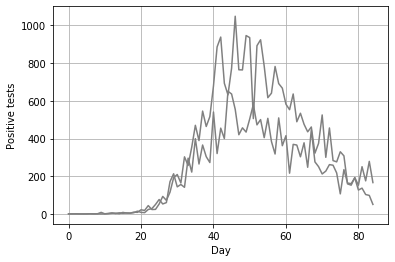

In [13]:
plt.clf()
plt.grid(True)
for x in sird:
    plt.plot(x.dpositive.values, '-', color='grey')
plt.xlabel("Day")
plt.ylabel("Positive tests")

Now we can fit the same model used above to see what we get:

In [14]:
fml = "D ~ "
fml += " + ".join(["logcumpos%d" % j for j in range(4)])
fml += " + "
fml += " + ".join(["logcumneg%d" % j for j in range(4)])
r4 = []
for x in sird:
    m4 = sm.GLM.from_formula(fml, data=x, family=sm.families.Poisson())
    r = m4.fit(scale="X2")
    print(r.summary())
    print(r.scale)
    r4.append(x)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      D   No. Observations:                   85
Model:                            GLM   Df Residuals:                       76
Model Family:                 Poisson   Df Model:                            8
Link Function:                    log   Scale:                         0.84139
Method:                          IRLS   Log-Likelihood:                -248.68
Date:                Mon, 01 Jun 2020   Deviance:                       66.067
Time:                        14:43:10   Pearson chi2:                     63.9
No. Iterations:                    14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -6.7249      5.827     -1.154      0.2

Qualitatively, the results are fairly similar to what we saw with
the actual Covid Tracking project data.  Note that the simulation
reflects data for a single state, whereas the actual data is for all
US states.  As a result, the actual data analysis has much greater
power.  In the simulated data, the coefficients for the log number
of positive tests are not always statistically significant.  As in
the actual data, their sum is around 0.8.